In [1]:
from mdss.ScoringFunctions.Bernoulli import Bernoulli
from mdss.ScoringFunctions.Poisson import Poisson
from mdss.MDSS import MDSS

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../project2_data_21_04_23.csv').drop(columns = 
       ['Unnamed: 0','study_id']).fillna(-999)
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc']
target_cols = ['diabetes_status_c_qc']

In [3]:
numeric_columns = [col for col in data.columns \
                     if (is_numeric_dtype(data[col])) \
                     & (col not in target_cols) \
                     & (data[col].nunique() > 10)]

In [4]:
site_id = 1 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id) & (data['age'] <= 60) & (data['age'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)].copy()
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1465, 25)
Size after removing records with missing targets:  (1465, 25)


In [5]:
dff1 = dff.replace([-999, -222, -111, 999], np.nan).copy()

<Axes: ylabel='Density'>

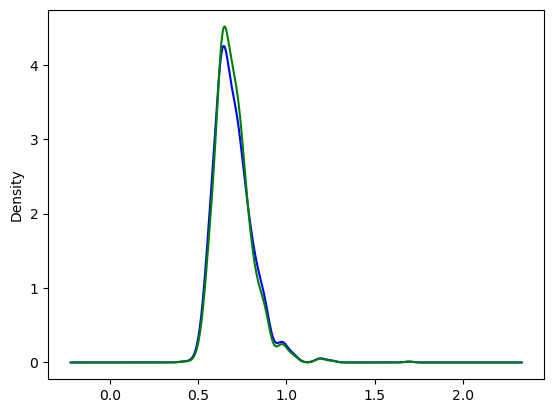

In [6]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff1)
train_t = imputer.transform(dff1)
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=dff1.columns)
# treated = treated.apply(np.ceil)
treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']]\
      = np.round(treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']], decimals=0)

fig = plt.figure()
ax = fig.add_subplot(111)
dff1['cimt_mean_max'].plot(kind='kde', ax=ax, color='blue')
treated['cimt_mean_max'].plot(kind='kde', ax=ax, color='green')

In [7]:
target_cols = ['diabetes_status_c_qc']
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc']
target_col = 'diab'
# target = 'MorbidityCount'

# Specify the columns of interest
columns_of_interest = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current'] 

# defining the target column to be a column where the sum of the target values >= 2
# dff[target_col] = (dff[target_cols] == 1).sum(axis = 1) == 2 # *****CHECK********
dff[target_col] = (dff[target_cols] == 1) # *******CHECK**********


# New column
dff['MorbidityCount'] = dff[columns_of_interest].sum(axis=1) # *******CHECK**********

# defining the expectations as mean of the target
dff['expectation'] = dff[target_col].mean()
dff['expectationPoisson'] = dff['MorbidityCount'].median()
# dff['expectation'].head()

# target_col = 'diab_hyp'

# defining the target column to be a column where the sum of the target values >= 2
treated[target_col] = (treated[target_cols] == 1).sum(axis = 1) == 1 # *******CHECK**********
treated['MorbidityCount'] = (treated[columns_of_interest] == 1).sum(axis = 1) # *******CHECK**********

# defining the expectations as mean of the target
treated['expectation'] = treated[target_col].mean()
treated['expectationPoisson'] = treated['MorbidityCount'].mean()

In [10]:
# Defining the search space to be all the features except site, study_id, 
# and our created target_col and expectations columns

search_space = [col for col in dff.columns \
                if col not in \
                [target_col, 'site', 'study_id', 'expectation', 'MorbidityCount','expectationPoisson',\
                'htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']]

In [11]:
search_space

['bmi_c_qc',
 'age',
 'cimt_mean_max',
 'cholesterol_1_qc',
 'friedewald_ldl_c_c_qc',
 'hdl_qc',
 'triglycerides_qc',
 'waist_hip_r_c_qc',
 'waist_circumference_qc',
 'visceral_fat_qc',
 'subcutaneous_fat_qc',
 'sex',
 'hiv_final_status_c',
 'highest_level_of_education_qc',
 'partnership_status_c_qc',
 'ses_site_quintile_c_qc',
 'occupation_qc',
 'mvpa_cat_c',
 'alcohol_use_status_c_qc',
 'smoking_status_c_qc']

In [12]:
def get_str(x):
    # This function turns a pandas bin to a meaningful string
    s = str(round(x.left, 2)) + ' - ' + str(round(x.right,2))
    return s

def custom_qcut(ser, contiguous = True):
    # Get the rows that are actual numbers
    sub_ser = ser[(ser != -111) \
                     & (ser != -222) \
                     & (ser != -555) \
                     & (ser != -999)]
    
    if contiguous:
        # if contiguous, treat all the special numbers the same
        ser = ser.replace(-111 , -999)
        ser = ser.replace(-222 , -999)
        ser = ser.replace(-555 , -999)

    # Bin the actual numbers into 10 bins for scanning
    sub_ser = pd.qcut(sub_ser, 10, duplicates='drop')
    sub_ser = sub_ser.apply(get_str).astype(str)
    ser[list(sub_ser.index)] = sub_ser
    return ser


In [ ]:
contiguous = {}
dff_2 = dff.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

In [13]:
contiguous = {}
dff_2 = treated.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

In [14]:
def compress_contiguous(subset, contiguous):
    # Shorten a contiguous list e.g [0-9, 10-19] is converted to [0 - 19] 
    new = {}
    
    for col in subset:
        if col in contiguous:
            if isinstance(subset[col][0], (float,int)):
                new[col] = [str(c) for c in subset[col]]
                continue
            i = -1 if isinstance(subset[col][-1], str) else -2
            new[col] = [subset[col][0].split(' - ')[0] + ' - ' + subset[col][i].split(' - ')[-1]]
            new[col] = new[col] if i == -1 else new[col] + [str(subset[col][-1])]
        else:
            new[col] = [str(c) for c in subset[col]]
    return new

def translate_subset_to_rule(subset):
    # Print the subset as a rule for easier understanding
    desc = ''
    for key, value in subset.items():
        # desc += key + ' = {' + ' OR '.join(value) + '} AND' + '\n'
        desc += key + '{' + ' OR '.join(value) + '} AND' + ' '

    return desc[:-5].replace('_',' ').replace('{', '[').replace('}', ']')

def count_conditions(subset):
    # Split the string by 'AND' and 'OR'
    conditions = subset.replace("AND", "OR").split("OR")
    
    # Count the number of conditions
    condition_count = len(conditions)
    
    return condition_count

In [66]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Poisson(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
# penalty_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
penalty_values = [1.0, 1.5, 2, 2.5]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
odds_results = []
count_results = []
dataframes = {}

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]

    # Store each DataFrame in the dictionary with a unique key
    dataframes[f'df_{penalty}'] = temp_df

    size = len(temp_df)
    observed_income = np.round(temp_df[target_col].mean(), 3)
    positive_class_count = temp_df[target_col].sum()

    group_obs = temp_df[target_col].mean()
    group_prob = temp_df['expectation'].mean()
    odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))
    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(np.round(score, 3))
    size_results.append(size)
    odds_results.append(np.round(odds_mul, 3))
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)


# # Display the results for each penalty value
# for i, penalty in enumerate(penalty_values):
#     print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, Odds = {odds_results[i]}, Score = {score_results[i]}")

Penalty = 1.0: Subset = friedewald ldl c c qc[1.37 - 7.6] AND waist circumference qc[510.0 - 810.0] AND age[40.0 - 55.0] AND subcutaneous fat qc[0.25 - 4.28], 
LiteralsNumber = 4, 
Size = 262, Odds = 0.0, Score = 12.99
Penalty = 1.5: Subset = cimt mean max[0.58 - 1.7] AND bmi c qc[14.53 - 21.35] AND mvpa cat c[1.0], 
LiteralsNumber = 3, 
Size = 197, Odds = 0.0, Score = 8.275
Penalty = 2: Subset = visceral fat qc[2.82 - 6.85] AND mvpa cat c[1.0] AND highest level of education qc[0.0 OR 2.0] AND waist hip r c qc[0.59 - 0.97], 
LiteralsNumber = 5, 
Size = 346, Odds = 0.0, Score = 12.437
Penalty = 2.5: Subset = mvpa cat c[1.0] AND waist circumference qc[510.0 - 780.0], 
LiteralsNumber = 2, 
Size = 259, Odds = 0.0, Score = 11.795


In [67]:
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Odds': odds_results,
    'Score': score_results
})
results_df

,Penalty,No of literals,Subset,Size,Odds,Score
0,1.0,4,friedewald ldl c c qc[1.37 - 7.6] AND waist ci...,262,0.0,12.990
1,1.5,3,cimt mean max[0.58 - 1.7] AND bmi c qc[14.53 -...,197,0.0,8.275
2,2.0,5,visceral fat qc[2.82 - 6.85] AND mvpa cat c[1....,346,0.0,12.437
3,2.5,2,mvpa cat c[1.0] AND waist circumference qc[510...,259,0.0,11.795


In [59]:
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Odds': odds_results,
    'Score': score_results
})
results_df

,Penalty,No of literals,Subset,Size,Odds,Score
0,1.0,3,cimt mean max[0.58 - 1.7] AND bmi c qc[14.53 -...,158,0.000,7.246
1,1.5,3,cimt mean max[0.58 - 1.7] AND bmi c qc[14.53 -...,197,0.000,8.275
2,2.0,3,waist circumference qc[510.0 - 990.0] AND subc...,555,0.184,11.528
3,2.5,2,mvpa cat c[1.0] AND waist circumference qc[510...,259,0.000,11.795


In [ ]:
# Process the 'Subset' column to split into sets of conditions
results_df['Subset'] = results_df['Subset'].apply(lambda x: set(x.split(' AND ')))

# Define the modified Hamming distance function
def modified_hamming_distance(set1, set2):
    # Extract condition names without value ranges
    names1 = {s.split('[')[0].strip() for s in set1}
    names2 = {s.split('[')[0].strip() for s in set2}
    
    # Calculate the difference in names
    unique_names1 = names1.difference(names2)
    unique_names2 = names2.difference(names1)
    
    # The modified Hamming distance is the count of unique elements
    distance = len(unique_names1) + len(unique_names2)
    return distance

# Re-calculate the modified Hamming distances with the correct data preparation
hamming_distances = [modified_hamming_distance(results_df['Subset'].iloc[i], results_df['Subset'].iloc[i+1]) for i in range(len(results_df) - 1)]

# Plot the Modified Hamming Distance over penalties
plt.figure(figsize=(10, 6))
plt.plot(results_df['Penalty'].iloc[:-1], hamming_distances, marker='o', linestyle='-', color='red')
plt.title('Modified Hamming Distance Across Penalties')
plt.xlabel('Penalty')
plt.ylabel('Modified Hamming Distance')
plt.grid(True)
plt.xticks(data['Penalty'].iloc[:-1])
plt.show()


In [73]:
results_df['Subset']

0    {subcutaneous fat qc[0.25 - 4.28], age[40.0 - ...
1    {mvpa cat c[1.0], cimt mean max[0.58 - 1.7], b...
2    {visceral fat qc[2.82 - 6.85], highest level o...
3    {waist circumference qc[510.0 - 780.0], mvpa c...
Name: Subset, dtype: object

In [ ]:
data = pd.read_csv('/Users/kayadetunji/Downloads/HAALSI_work/mdscan-master/Poisson_counts_neg.csv')

def modified_hamming_distance(set1, set2):
    # Extract condition names without value ranges
    names1 = {s.split('[')[0].strip() for s in set1}
    names2 = {s.split('[')[0].strip() for s in set2}
    
    # Calculate the difference in names
    unique_names1 = names1.difference(names2)
    unique_names2 = names2.difference(names1)
    
    # The modified Hamming distance is the count of unique elements
    distance = len(unique_names1) + len(unique_names2)
    return distance

# Assuming 'data' DataFrame is already prepared
hamming_distances = [modified_hamming_distance(data['Subset'].iloc[i], data['Subset'].iloc[i+1]) for i in range(len(data['Subset'])-1)]

# Plotting the Modified Hamming Distance over penalties
plt.figure(figsize=(10, 6))
plt.plot(data['Penalty'][:-1], hamming_distances, marker='o', linestyle='-', color='red')
plt.title('Modified Hamming Distance Across Penalties')
plt.xlabel('Penalty')
plt.ylabel('Modified Hamming Distance')
plt.grid(True)
plt.show()

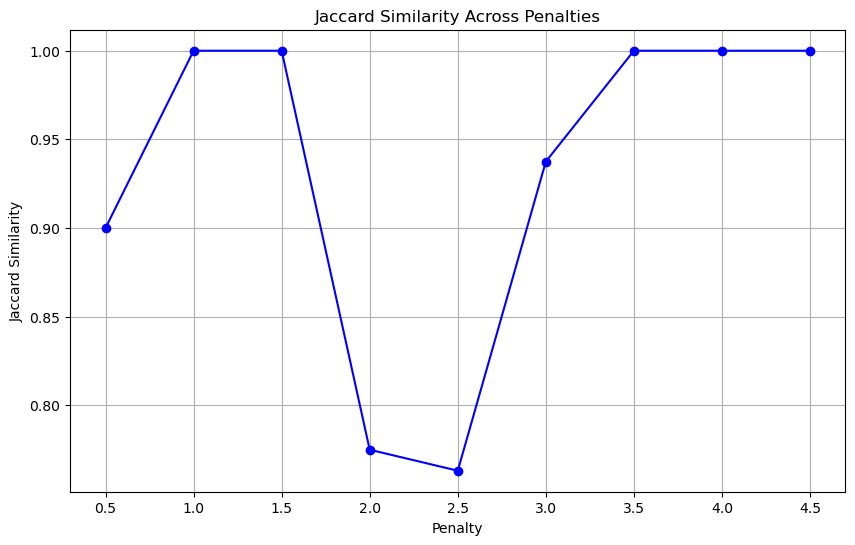

In [77]:
# Function to calculate Jaccard similarity between two sets
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0
jaccard_similarities = []
for i in range(1, len(data['Subset'])):
    set1 = set(data['Subset'].iloc[i-1])
    set2 = set(data['Subset'].iloc[i])
    similarity = jaccard_similarity(set1, set2)
    jaccard_similarities.append(similarity)
# Calculate Jaccard similarities for consecutive subsets
# jaccard_similarities = [jaccard_similarity(data['Subset'].iloc[i], data['Subset'].iloc[i+1]) for i in range(len(data['Subset'])-1)]

# Plot Jaccard Similarity over penalties
plt.figure(figsize=(10, 6))
plt.plot(data['Penalty'][:-1], jaccard_similarities, marker='o', linestyle='-', color='blue')
plt.title('Jaccard Similarity Across Penalties')
plt.xlabel('Penalty')
plt.ylabel('Jaccard Similarity')
plt.grid(True)
plt.show()


In [ ]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# penalty_values = [1.0, 1.5, 2, 2.5]
num_iters = 1
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
odds_results = []
count_results = []
dataframes = {}


# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]

    # Store each DataFrame in the dictionary with a unique key
    dataframes[f'df_{penalty}'] = temp_df

    size = len(temp_df)
    observed_income = np.round(temp_df[target_col].mean(), 3)
    positive_class_count = temp_df[target_col].sum()

    group_obs = temp_df[target_col].mean()
    group_prob = temp_df['expectation'].mean()
    odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))
    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(np.round(score, 3))
    size_results.append(size)
    odds_results.append(np.round(odds_mul, 3))
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)


# # Display the results for each penalty value
# for i, penalty in enumerate(penalty_values):
#     print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, Odds = {odds_results[i]}, Score = {score_results[i]}")

In [84]:
scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [0.1, 0.2, 0.5, 0.6, 0.7, 0.8]
# penalty_values = [1.0, 1.5, 2, 2.5]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
odds_results = []
count_results = []
dataframes = {}

# Initialize an empty DataFrame to store results
columns = ['Iteration', 'Penalty', 'SubsetRule', 'LiteralsNumber', 'Size', 'Odds', 'Score']
results_df = pd.DataFrame(columns=columns)

# Loop through iteration numbers
for iteration in range(1, num_iters):  # From 1 to 10
    for penalty in penalty_values:
        # Perform the scan with the current penalty value
        subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                    penalty=penalty, num_iters=iteration, contiguous=contiguous.copy())
        
        to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
        temp_df = dff_2.loc[to_choose]

        # Calculate additional metrics as before
        size = len(temp_df)
        group_obs = temp_df[target_col].mean()
        group_prob = temp_df['expectation'].mean()
        odds_mul = (group_obs / (1 - group_obs)) / (group_prob / (1 - group_prob))
        counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

        # Append the results to the DataFrame
        results_df = results_df.append({
            'Iteration': iteration,
            'Penalty': penalty,
            'SubsetRule': translate_subset_to_rule(compress_contiguous(subset, contiguous)),
            'LiteralsNumber': counting,
            'Size': size,
            'Odds': np.round(odds_mul, 3),
            'Score': np.round(score, 3)
        }, ignore_index=True)

# After the loops, you'll have a DataFrame populated with all your results
# You can then use this DataFrame for analysis or export it to a file


In [85]:
results_df

,Iteration,Penalty,SubsetRule,LiteralsNumber,Size,Odds,Score
0,1,0.1,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,8.048
1,1,0.2,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,7.648
2,1,0.5,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,6.448
3,1,0.6,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,6.048
4,1,0.7,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,5.648
5,1,0.8,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,5.248
6,2,0.1,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,8.048
7,2,0.2,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,7.648
8,2,0.5,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,6.448
9,2,0.6,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,6.048


In [86]:
results_df.to_csv('iteration_pen_neg.csv', index=False)

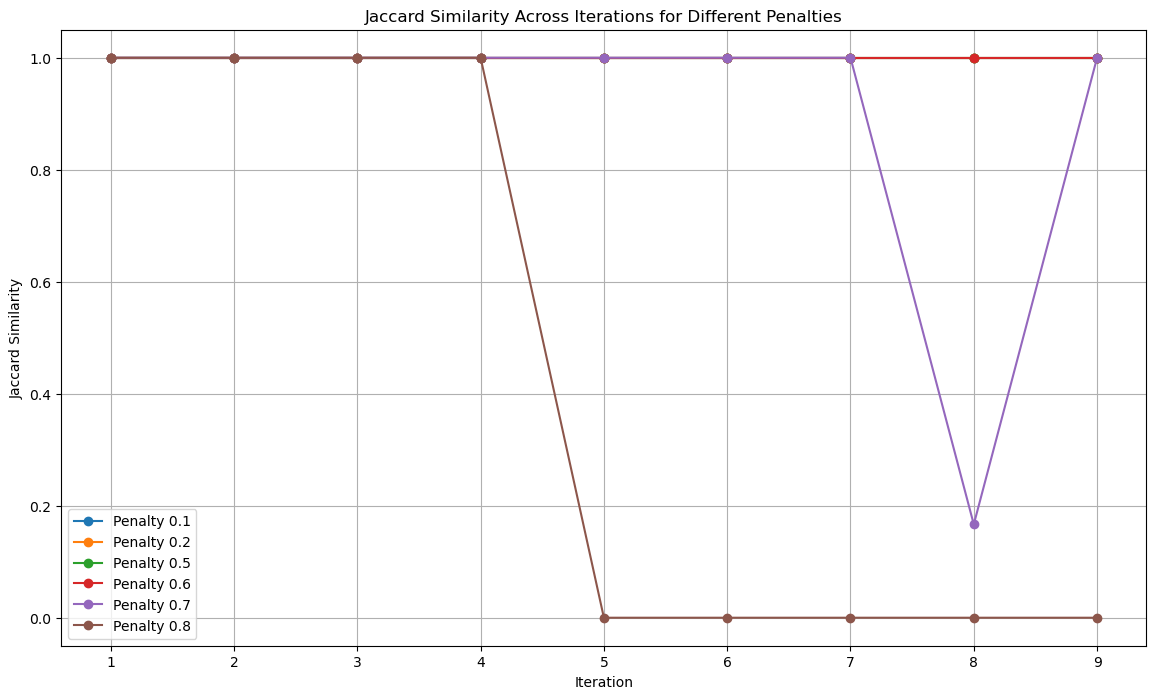

In [90]:
# Split the 'SubsetRule' into individual subsets for Jaccard similarity calculation
results_df['Subset'] = results_df['SubsetRule'].apply(lambda x: set(x.split(' AND ')))

# Calculate Jaccard similarity for each penalty within each iteration
def calculate_jaccard_similarity(group):
    subsets = list(group['Subset'])
    similarities = [1]  # Start with 1 for the first subset comparison within each group
    for i in range(len(subsets) - 1):
        set1 = subsets[i]
        set2 = subsets[i + 1]
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        similarity = intersection / union if union else 1
        similarities.append(similarity)
    return pd.Series(similarities, index=group.index)

# Apply Jaccard similarity calculation for each group of iterations
results_df['JaccardSimilarity'] = results_df.groupby('Iteration').apply(calculate_jaccard_similarity).reset_index(level=0, drop=True)

# Plotting
plt.figure(figsize=(14, 8))
for penalty in results_df['Penalty'].unique():
    subset_data = results_df[results_df['Penalty'] == penalty]
    plt.plot(subset_data['Iteration'], subset_data['JaccardSimilarity'], marker='o', label=f'Penalty {penalty}')

plt.xlabel('Iteration')
plt.ylabel('Jaccard Similarity')
plt.title('Jaccard Similarity Across Iterations for Different Penalties')
plt.legend()
plt.grid(True)
plt.show()

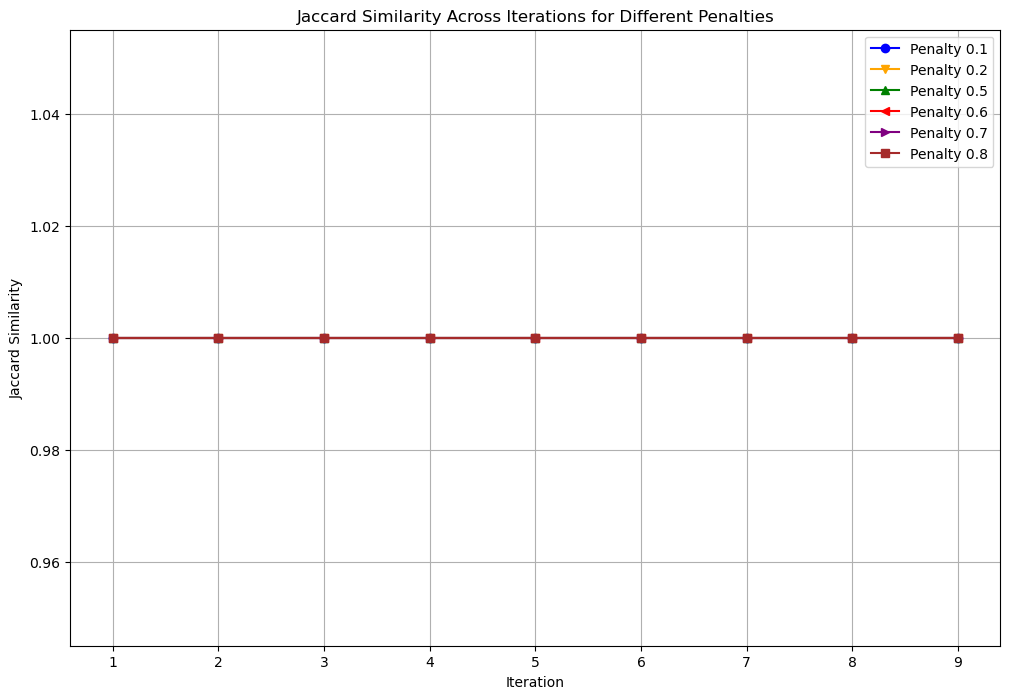

In [92]:
# Preprocess 'SubsetRule' into a set of rules for Jaccard similarity calculation
# data['Subset'] = data['SubsetRule'].apply(lambda x: set(x.split(' AND ')))

# Function to calculate Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union else 0

# Calculate Jaccard similarity for each penalty within each iteration
jaccard_similarities = results_df.groupby(['Iteration', 'Penalty']).apply(lambda df: jaccard_similarity(df['Subset'].iloc[0], df['Subset'].iloc[-1]) if len(df['Subset']) > 1 else 1).reset_index(name='JaccardSimilarity')

# Plotting each penalty value with different markers and colors
plt.figure(figsize=(12, 8))
penalty_values = jaccard_similarities['Penalty'].unique()
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd']

for i, penalty in enumerate(penalty_values):
    subset = jaccard_similarities[jaccard_similarities['Penalty'] == penalty]
    plt.plot(subset['Iteration'], subset['JaccardSimilarity'], marker=markers[i % len(markers)], color=colors[i % len(colors)], linestyle='-', label=f'Penalty {penalty}')

plt.xlabel('Iteration')
plt.ylabel('Jaccard Similarity')
plt.title('Jaccard Similarity Across Iterations for Different Penalties')
plt.legend()
plt.grid(True)
plt.show()

In [100]:
dfs_by_penalty = {penalty: group for penalty, group in results_df.groupby('Penalty')}

In [110]:
dfs_by_penalty[0.8]

,Iteration,Penalty,SubsetRule,LiteralsNumber,Size,Odds,Score,Subset,JaccardSimilarity
5,1,0.8,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.0,5.248,"{visceral fat qc[2.82 - 12.4], ses site quinti...",1.0
11,2,0.8,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.0,5.248,"{visceral fat qc[2.82 - 12.4], ses site quinti...",1.0
17,3,0.8,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.0,5.248,"{visceral fat qc[2.82 - 12.4], ses site quinti...",1.0
23,4,0.8,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.0,5.248,"{visceral fat qc[2.82 - 12.4], ses site quinti...",1.0
29,5,0.8,waist circumference qc[510.0 - 780.0] AND mvpa...,2,259,0.0,15.765,"{waist circumference qc[510.0 - 780.0], mvpa c...",0.0
35,6,0.8,waist circumference qc[510.0 - 780.0] AND mvpa...,2,259,0.0,15.765,"{waist circumference qc[510.0 - 780.0], mvpa c...",0.0
41,7,0.8,waist circumference qc[510.0 - 780.0] AND mvpa...,2,259,0.0,15.765,"{waist circumference qc[510.0 - 780.0], mvpa c...",0.0
47,8,0.8,waist circumference qc[510.0 - 780.0] AND mvpa...,2,259,0.0,15.765,"{waist circumference qc[510.0 - 780.0], mvpa c...",0.0
53,9,0.8,waist circumference qc[510.0 - 780.0] AND mvpa...,2,259,0.0,15.765,"{waist circumference qc[510.0 - 780.0], mvpa c...",0.0


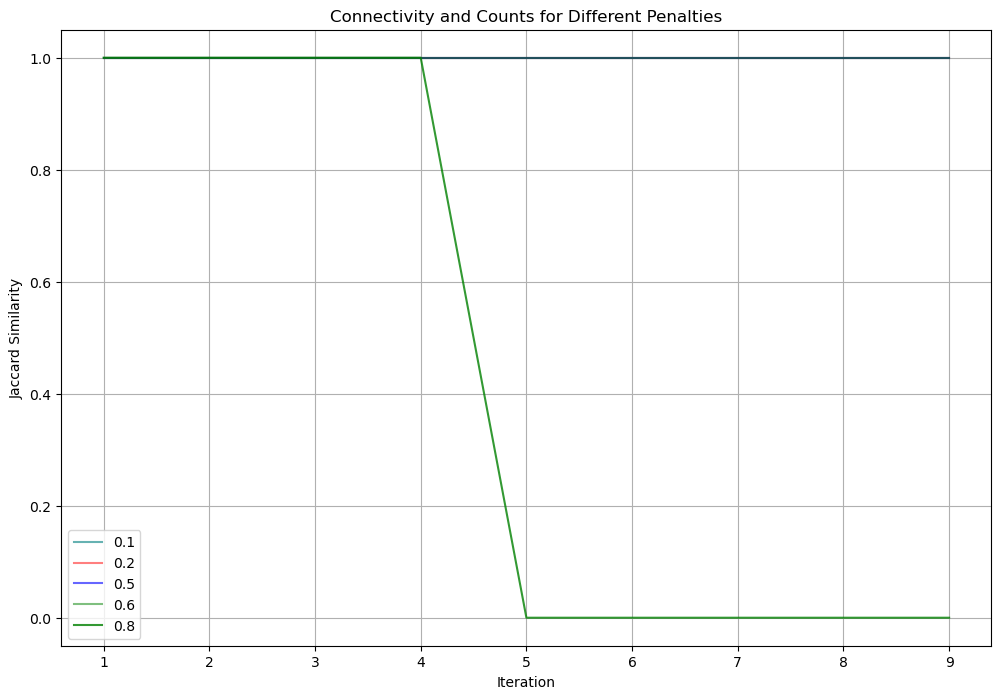

In [121]:
fig=plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
# Plot size
plt.plot(dfs_by_penalty[0.1]['Iteration'], dfs_by_penalty[0.1]['JaccardSimilarity'], label='0.1', color='teal', alpha=0.6)
plt.plot(dfs_by_penalty[0.2]['Iteration'], dfs_by_penalty[0.2]['JaccardSimilarity'], label='0.2', color='red', alpha=0.5)
plt.plot(dfs_by_penalty[0.5]['Iteration'], dfs_by_penalty[0.5]['JaccardSimilarity'], label='0.5', color='blue', alpha=0.6)
plt.plot(dfs_by_penalty[0.6]['Iteration'], dfs_by_penalty[0.6]['JaccardSimilarity'], label='0.6', color='green', alpha=0.5)
plt.plot(dfs_by_penalty[0.8]['Iteration'], dfs_by_penalty[0.8]['JaccardSimilarity'], label='0.8', color='green', alpha=0.8)
plt.title('Connectivity and Counts for Different Penalties')
plt.xlabel('Iteration')
plt.ylabel('Jaccard Similarity')
# plt.xticks(dfs_by_penalty[0.1]['Iteration'])
plt.legend()
plt.grid(True)
plt.show()
# dfs_by_penalty[0.1]

,Iteration,Penalty,SubsetRule,LiteralsNumber,Size,Odds,Score,Subset,JaccardSimilarity
0,1,0.1,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,8.048,"{visceral fat qc[2.82 - 12.4], ses site quinti...",1.000000
1,1,0.2,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,7.648,"{visceral fat qc[2.82 - 12.4], ses site quinti...",1.000000
2,1,0.5,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,6.448,"{visceral fat qc[2.82 - 12.4], ses site quinti...",1.000000
3,1,0.6,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,6.048,"{visceral fat qc[2.82 - 12.4], ses site quinti...",1.000000
4,1,0.7,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,5.648,"{visceral fat qc[2.82 - 12.4], ses site quinti...",1.000000
5,1,0.8,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,5.248,"{visceral fat qc[2.82 - 12.4], ses site quinti...",1.000000
6,2,0.1,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,8.048,"{visceral fat qc[2.82 - 12.4], ses site quinti...",1.000000
7,2,0.2,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,7.648,"{visceral fat qc[2.82 - 12.4], ses site quinti...",1.000000
8,2,0.5,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,6.448,"{visceral fat qc[2.82 - 12.4], ses site quinti...",1.000000
9,2,0.6,visceral fat qc[2.82 - 12.4] AND hiv final sta...,4,126,0.000,6.048,"{visceral fat qc[2.82 - 12.4], ses site quinti...",1.000000


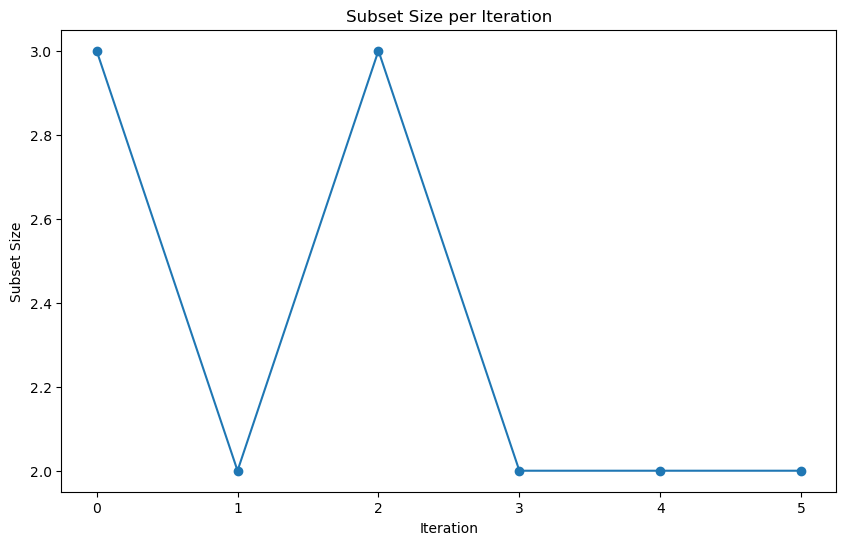

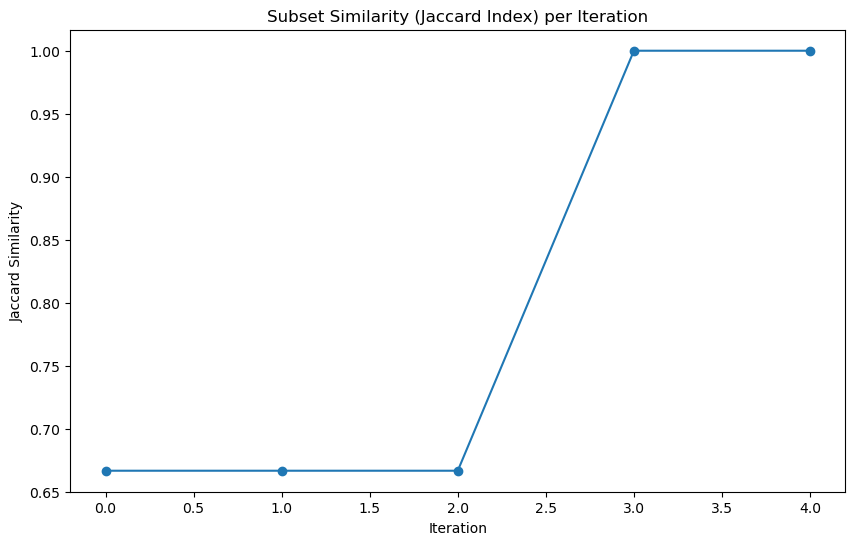

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Example subsets produced by your algorithm over iterations
subsets = [
    {'A', 'B', 'C'},
    {'A', 'C'},
    {'A', 'C', 'D'},
    {'C', 'D'},
    {'C', 'D'},  # Assuming convergence starts here
    {'C', 'D'},
]

# 1. Plot Subset Sizes
subset_sizes = [len(subset) for subset in subsets]
plt.figure(figsize=(10, 6))
plt.plot(subset_sizes, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Subset Size')
plt.title('Subset Size per Iteration')
plt.show()

# 2. Calculate and Plot Subset Similarity (Jaccard Index)
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

similarities = [jaccard_similarity(subsets[i], subsets[i+1]) for i in range(len(subsets)-1)]
plt.figure(figsize=(10, 6))
plt.plot(similarities, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Jaccard Similarity')
plt.title('Subset Similarity (Jaccard Index) per Iteration')
plt.show()
